# Benchmark of Active Learning

### tools

In [1]:
import pandas as pd
import os
import numpy as np

In [2]:
from scipy import stats

In [3]:
import matplotlib.pyplot as plt

In [4]:
def align_idx(idxArr_list):
    res = idxArr_list[0]
    for idxArr in idxArr_list[1:]:
        if idxArr is None:
            continue

        res = np.intersect1d(res, idxArr)
    return res

In [5]:
def tinterval_check(mean_poy, std_poy, n_poy, mean_XZ2021):
    se = std_poy / np.sqrt(n_poy)
    ci_95 = stats.t.interval(alpha=0.95, df=n_poy-1, loc=mean_poy, scale=se)
    if ci_95[0] <= mean_XZ2021 <= ci_95[1]:
        decision_95 = 0  # not significantly different with 95 confidence interval
    else:
        decision_95 = 1  # significantly different with 95 confidence interval

    ci_99 = stats.t.interval(alpha=0.99, df=n_poy-1, loc=mean_poy, scale=se)
    if ci_99[0] <= mean_XZ2021 <= ci_99[1]:
        decision_99 = 0  # not significantly different with 95 confidence interval
    else:
        decision_99 = 1  # significantly different with 95 confidence interval

    return decision_95, decision_99

### Download all results

Link: [https://drive.google.com/file/d/1qzezDD_fe43ctNBHC4H5W0w6skJcBlxB/view?usp=share_link](https://drive.google.com/file/d/1qzezDD_fe43ctNBHC4H5W0w6skJcBlxB/view?usp=share_link)

## Align results

We align all results on
- small datasets $n < 2000$ : more than 100 indicis
- large datasets $n \geq 2000$ : more than 10 indicis.

In [6]:
qs_list = ['uniform', 'us', 'qbc', 'hintsvm', 'quire', 'albl', 'dwus', 'vr', 'kcenter',  # libact
           'margin', 'graph', 'hier', 'infodiv', 'mcm',  # google
           'eer', 'bmdr', 'spal', 'lal',  # alipy
           'bsoDtst']
small_data_list = ["appendicitis", "sonar", "parkinsons", "ex8b", "heart", "haberman", "ionosphere", "clean1",
             "breast", "wdbc", "australian", "diabetes", "mammographic", "ex8a", "tic", "german",
             "splice", "gcloudb", "gcloudub", "checkerboard"]
large_data_list = ["spambase", "banana", "phoneme", "ringnorm", "twonorm", "phishing"]
data_list = small_data_list + large_data_list

In [7]:
names = os.listdir('./aubc/')
qs_map_pos = {k: i for i, k in enumerate(qs_list)}
table3_idx = {k: [None for _ in range(len(qs_list))] for k in data_list}

In [8]:
for name in names:
    if not name.endswith('.csv'):
        continue
    terms = name.split('-')
    if 'look' in name:
        qs = terms[1] + terms[6].split('_')[-1][-4:]
    else:
        qs = terms[1]

    data = terms[0]

    res = pd.read_csv(os.path.join('./aubc/', name))

    idx = res['res_expno'].unique()

    if data in large_data_list:
        if len(idx) < 10:
            print(f'{data}-{qs}: {len(idx)} < 10 times')
            continue
    else:
        if len(idx) < 100:
            print(f'{data}-{qs}: {len(idx)} < 100 times')
            continue

    table3_idx[data][qs_map_pos[qs]] = idx

clean1-vr: 8 < 100 times
phoneme-vr: 6 < 10 times
checkerboard-spal: 96 < 100 times
spambase-quire: 1 < 10 times


In [9]:
aligned_idx = []
for data in table3_idx:
    align_idx_arr = align_idx(table3_idx[data])
    n_exp = len(align_idx_arr)
    if data in large_data_list:
        align_idx_arr = align_idx_arr[:10]
        assert align_idx_arr.shape[0] == 10, f'Size of {data} is not correct. {(align_idx_arr.shape[0])}'
    else:
        align_idx_arr = align_idx_arr[:100]
        assert align_idx_arr.shape[0] == 100, f'Size of {data} is not correct. {(align_idx_arr.shape[0])}'

    aligned_idx.append([data, n_exp, f'{align_idx_arr.tolist()}'])

aligned_idx = pd.DataFrame(aligned_idx)
# aligned_idx.to_csv('output/aligned_idx.csv')

In [10]:
aligned_idx.head()

,0,1,2
0,appendicitis,150,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
1,sonar,140,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
2,parkinsons,150,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
3,ex8b,148,"[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14..."
4,heart,150,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


## Mean AUBCs

- small datasets $n < 2000$ : only use first 100 indicis
- large datasets $n \geq 2000$ : only use first 10 indicis.

Calculate average (mean) and standard deviation of AUBCs.

In [11]:
aligned_idx_dict = {}
for data, idx in zip(aligned_idx[0], aligned_idx[2]):
    aligned_idx_dict[data] = eval(idx)

In [12]:
table3_mean = []
table3_std = []
index = []
for name in names:
    if not name.endswith('.csv'):
        continue

    terms = name.split('-')
    if 'look' in name:
        qs = terms[1] + terms[6].split('_')[-1][-4:]
    else:
        qs = terms[1]

    data = terms[0]

    if (data, qs) in index:
        breakpoint()

    index.append((data, qs))
    res = pd.read_csv(os.path.join('./aubc/', name))

    # aligned index
    if aligned_idx_dict is not None:
        res = res[res['res_expno'].isin(aligned_idx_dict[data])]

    cnt_aubc = res['res_tst_score'].count()
    if data in large_data_list:
        if cnt_aubc < 10:
            continue
    else:
        if cnt_aubc < 100:
            continue

    mean_aubc = res['res_tst_score'].mean()
    std_aubc = res['res_tst_score'].std()
    mean_aubc = round(mean_aubc, 4)
    std_aubc = round(std_aubc, 4)

    table3_mean.append([data, qs, mean_aubc])
    table3_std.append([data, qs, std_aubc])

In [13]:
table3_mean = pd.DataFrame(table3_mean)
table3_std = pd.DataFrame(table3_std)

table3_mean.columns = ['data', 'qs', 'aubc_mean']
table3_std.columns = ['data', 'qs', 'aubc_std']

table3_mean = pd.pivot(table3_mean, values='aubc_mean', index=['qs'], columns=['data'])
table3_std = pd.pivot(table3_std, values='aubc_std', index=['qs'], columns=['data'])

In [14]:
table3_mean = table3_mean.reindex(index=qs_list, columns=data_list)
table3_std = table3_std.reindex(index=qs_list, columns=data_list)

~~Export to LaTeX.~~
$\rightarrow$
Export to GitHub.

In [15]:
al_methods = qs_list[1:-1]

In [16]:
# largest three values in each column
# make them as bold, bold, underline
lbracebracket = f'{chr(123)}'
rbracebracket = f'{chr(125)}'
tbf = f'{chr(92)}textbf'
tit = f'{chr(92)}textit'
udl = f'{chr(92)}underline'
# str of mean and std AUBCs
report1_mean = table3_mean.astype(str)
report1_std = table3_std.astype(str)
for d in table3_mean.columns:
    bst_q = table3_mean.loc[al_methods, d].nlargest(3+1).index  # as margin == infodiv in the current setting
    if 'infodiv' not in bst_q:
        bst_q = bst_q[:3]
    else:
        bst_q = bst_q.drop('infodiv')

    # # export to GitHub
    report1_mean.loc[bst_q[0], d] = f'{report1_mean.loc[bst_q[0], d]}¹'
    report1_mean.loc[bst_q[1], d] = f'{report1_mean.loc[bst_q[1], d]}²'
    report1_mean.loc[bst_q[2], d] = f'{report1_mean.loc[bst_q[2], d]}³'
    # # export to LaTeX
    # report1_mean.loc[bst_q[0], d] = f'{tbf}{lbracebracket}{tit}{lbracebracket}{report1_mean.loc[bst_q[0], d]}{rbracebracket}{rbracebracket}'
    # report1_mean.loc[bst_q[1], d] = f'{tbf}{lbracebracket}{report1_mean.loc[bst_q[1], d]}{rbracebracket}'
    # report1_mean.loc[bst_q[2], d] = f'{tit}{lbracebracket}{report1_mean.loc[bst_q[2], d]}{rbracebracket}'

    bst_q_std = table3_std.loc[al_methods, d].nsmallest(3+1).index
    if 'infodiv' not in bst_q_std:
        bst_q_std = bst_q_std[:3]
    else:
        bst_q_std = bst_q_std.drop('infodiv')

    # # export to GitHub
    report1_std.loc[bst_q_std[0], d] = f'{report1_std.loc[bst_q_std[0], d]}¹'
    report1_std.loc[bst_q_std[1], d] = f'{report1_std.loc[bst_q_std[1], d]}²'
    report1_std.loc[bst_q_std[2], d] = f'{report1_std.loc[bst_q_std[2], d]}³'
    # # export to LaTeX
    # report1_std.loc[bst_q_std[0], d] = f'{tbf}{lbracebracket}{tit}{lbracebracket}{report1_std.loc[bst_q_std[0], d]}{rbracebracket}{rbracebracket}'
    # report1_std.loc[bst_q_std[1], d] = f'{tbf}{lbracebracket}{tit}{lbracebracket}{report1_std.loc[bst_q_std[1], d]}{rbracebracket}{rbracebracket}'
    # report1_std.loc[bst_q_std[2], d] = f'{tbf}{lbracebracket}{tit}{lbracebracket}{report1_std.loc[bst_q_std[2], d]}{rbracebracket}{rbracebracket}'

In [17]:
report1 = report1_mean + '(' + report1_std + ')'
report_index = ['uniform', 'us', 'qbc', 'hintsvm', 'quire', 'albl', 'dwus', 'vr',
                'kcenter', 'margin', 'graph', 'hier', 'infodiv', 'mcm', 'eer', 'bmdr',
                'spal', 'lal', 'bsoDtst']
report1 = report1.loc[report_index, :]
report1.index = ['uniform', 'us', 'qbc', 'hintsvm', 'quire', 'albl', 'dwus', 'vr',
                'kcenter', 'margin', 'graph', 'hier', 'infodiv', 'mcm', 'eer', 'bmdr',
                'spal', 'lal', 'bso']

report1 = report1.T

In [18]:
report1 = report1.replace(to_replace='nan(nan)', value='too long (time)')

In [19]:
# checkerboard-spal: 96 < 100 times
# spambase-quire: 1 < 10 times
report1.loc['checkerboard', 'spal'] = 'error'
report1.loc['spambase', 'quire'] = 'error'

In [20]:
# Add XZ2021 results
xz2021_table3 = pd.read_csv('table3-xz2021.csv')
xz2021_table3 = xz2021_table3.set_index('XZ2021')

In [21]:
# export to GitHub as Markdown file
report1_str = report1.to_markdown()

In [22]:
report1_str = '# Benchmark of pool-based active learning\n\nMean(Standard Deviation) of Uniform (Random Sampling), 17 query strategies and Beam-Search Oracle (BSO) on 26 binary datasets.\n\n' + report1_str

In [23]:
with open('./README.md', 'w') as f:
    f.write(report1_str)

In [24]:
# # export to LaTeX
# xz2021_table3_data = xz2021_table3.index
# for d in xz2021_table3_data:
#     qs = xz2021_table3.loc[d, 'BEST_mhd']
#     report1.loc[d, qs] = f'{udl}{lbracebracket}{report1.loc[d, qs]}{rbracebracket}'
#     qs = xz2021_table3.loc[d, 'WORST_mhd']
#     report1.loc[d, qs] = f'{udl}{lbracebracket}{report1.loc[d, qs]}{rbracebracket}'
#     qs = 'uniform'
#     report1.loc[d, qs] = f'{udl}{lbracebracket}{report1.loc[d, qs]}{rbracebracket}'
#     qs = 'bso'
#     report1.loc[d, qs] = f'{udl}{lbracebracket}{report1.loc[d, qs]}{rbracebracket}'

In [25]:
# # export to LaTeX
# with pd.option_context("max_colwidth", -1):
#     for i, col_i in enumerate(range(0, 24, 6)):
#         report1.iloc[:, col_i:col_i+6].to_latex(f'./aubc/output/table1-intermediate-{i}.tex',
#                                                 caption='Intermediate table of mean(std) AUBCs',
#                                                 escape=False)

## Reproducibility of Table 3

We check whether mean of AUBCs in [Zhan et al., 2021] locating in
- confidence interval with $\alpha=0.05$ significance level.
- confidence interval with $\alpha=0.01$ significance level.

We suppose both of experiments have the same settings.
They will generate independent, identical distribution (i.i.d.) results.

*ChatGPT*
> If you have the mean of one sample and you want to compare it to the median of another sample, you can use the confidence interval for the mean of the first sample to see if the median of the second sample falls within the interval. This will give you an idea of whether the median of the second sample is significantly different from the mean of the first sample, but it will not be the same as the Mann-Whitney U test, which compares the medians of two independent samples.
> This will calculate the 95% confidence interval for the mean of the first sample. You can then compare the median of the second sample to this interval to see if it falls within the interval. If the median falls within the interval, it suggests that the median is not significantly different from the mean of the first sample. If the median falls outside the interval, it suggests that the median is significantly different from the mean of the first sample.
> Keep in mind that this approach will give you an idea of whether the median of the second sample is significantly different from the mean of the first sample, but it will not provide a formal hypothesis test or p-value like the Mann-Whitney U test.

In [26]:
xz2021_table3.columns = ['uniform', 'bsoDtst', 'Avg', 'BEST_val', 'BEST_mhd', 'WORST_val', 'WORST_mhd']
xz2021_table3.head()

,uniform,bsoDtst,Avg,BEST_val,BEST_mhd,WORST_val,WORST_mhd
XZ2021,,,,,,,
appendicitis,0.836,0.881,0.844,0.859,eer,0.826,dwus
sonar,0.617,0.830,0.755,0.775,lal,0.732,hintsvm
parkinsons,0.840,0.865,0.845,0.858,qbc,0.829,hintsvm
ex8b,0.866,0.924,0.890,0.909,spal,0.864,hintsvm
heart,0.808,0.848,0.787,0.830,infodiv,0.718,dwus


Focus on Random Sampling (RS, **Uniform**).

In [27]:
report4_1 = pd.DataFrame()
report4_1.loc[:, 'mean'] = table3_mean.loc['uniform', :]
report4_1.loc[:, 'SD'] = table3_std.loc['uniform', :]
report4_1.loc[:, '\cite{XZ2021}'] = xz2021_table3['uniform']
report4_1.loc[:, '$\\alpha=5\%$'] = None
report4_1.loc[:, '$\\alpha=1\%$'] = None
report4_1.index.name = f'{report4_1.index.name}($\%$)'

In [28]:
for data_name in report4_1.index:
    if data_name in large_data_list:
        n_samples = 10
    else:
        n_samples = 100

    d_95, d_99 = tinterval_check(
        report4_1.loc[data_name, 'mean'],
        report4_1.loc[data_name, 'SD'],
        n_samples,
        report4_1.loc[data_name, '\cite{XZ2021}']
    )

    if d_95 == 1:
        report4_1.loc[data_name, '$\\alpha=5\%$'] = f'Out'
    else:
        report4_1.loc[data_name, '$\\alpha=5\%$'] = f'In'

    if d_99 == 1:
        report4_1.loc[data_name, '$\\alpha=1\%$'] = f'Out'
    else:
        report4_1.loc[data_name, '$\\alpha=1\%$'] = f'In'

In [29]:
report4_1['mean'] = report4_1['mean'].apply(lambda x: f'{x:.2%}'[:-1])
report4_1['SD'] = report4_1['SD'].apply(lambda x: f'{x:.2%}'[:-1])
report4_1['\cite{XZ2021}'] = report4_1['\cite{XZ2021}'].apply(lambda x: f'{x:.1%}'[:-1])
report4_1.head()

,mean,SD,\cite{XZ2021},$\alpha=5\%$,$\alpha=1\%$
data($\%$),,,,,
appendicitis,83.95,3.63,83.6,In,In
sonar,74.63,3.79,61.7,Out,Out
parkinsons,83.05,3.68,84.0,Out,In
ex8b,88.53,2.80,86.6,Out,Out
heart,80.51,2.79,80.8,In,In


In [30]:
report4_1.to_latex('./aubc/output/rsfail.tex',
                   label='tab2:rsfail',
                   caption='Reporducing Failure of \\textbf{Uniform}',
                   escape=False)

Focus on Beam-Search Oracle **BSO**.

In [31]:
report4_2 = pd.DataFrame()
report4_2.loc[:, 'mean'] = table3_mean.loc['bsoDtst', :]
report4_2.loc[:, 'SD'] = table3_std.loc['bsoDtst', :]
report4_2.loc[:, '\cite{XZ2021}'] = xz2021_table3['bsoDtst']
report4_2.loc[:, '$\\alpha=5\%$'] = None
report4_2.loc[:, '$\\alpha=1\%$'] = None
report4_2.index.name = f'{report4_2.index.name}($\%$)'

In [32]:
n_samples = 100
for data_name in report4_2.index:
    if data_name in large_data_list:
        continue

    d_95, d_99 = tinterval_check(
        report4_2.loc[data_name, 'mean'],
        report4_2.loc[data_name, 'SD'],
        n_samples,
        report4_2.loc[data_name, '\cite{XZ2021}']
    )

    if d_95 == 1:
        report4_2.loc[data_name, '$\\alpha=5\%$'] = f'Out'
    else:
        report4_2.loc[data_name, '$\\alpha=5\%$'] = f'In'

    if d_99 == 1:
        report4_2.loc[data_name, '$\\alpha=1\%$'] = f'Out'
    else:
        report4_2.loc[data_name, '$\\alpha=1\%$'] = f'In'

In [33]:
report4_2['mean'] = report4_2['mean'].apply(lambda x: f'{x:.2%}'[:-1])
report4_2['SD'] = report4_2['SD'].apply(lambda x: f'{x:.2%}'[:-1])
report4_2['\cite{XZ2021}'] = report4_2['\cite{XZ2021}'].apply(lambda x: f'{x:.1%}'[:-1])
report4_2 = report4_2.iloc[:-6, :]
report4_2.head()

,mean,SD,\cite{XZ2021},$\alpha=5\%$,$\alpha=1\%$
data($\%$),,,,,
appendicitis,88.37,2.95,88.1,In,In
sonar,88.40,2.84,83.0,Out,Out
parkinsons,88.28,3.19,86.5,Out,Out
ex8b,93.76,1.82,92.4,Out,Out
heart,89.30,2.47,84.8,Out,Out


In [34]:
report4_2.to_latex('./aubc/output/bsofail.tex',
                   label='tab2:bsofail',
                   caption='Reporducing Failure of \\textbf{BSO}',
                   escape=False)

Re-Benchmark Table 3.

In [35]:
report4 = xz2021_table3.copy().applymap(lambda x: None)

In [36]:
# 1. deal with uniform and bso
for qs_name in ['uniform', 'bsoDtst']:
    for data_name in report4.index:
        if data_name in large_data_list:
            n_samples = 10
        else:
            n_samples = 100

        if np.isnan(xz2021_table3.loc[data_name, qs_name]):
            continue
            
        d_95, d_99 = tinterval_check(
            table3_mean.loc[qs_name, data_name],
            table3_std.loc[qs_name, data_name],
            n_samples,
            xz2021_table3.loc[data_name, qs_name]
        )

        # update value with Poy's results
        report4.loc[data_name, qs_name] = f'{table3_mean.loc[qs_name, data_name]:.2%}'[:-1]

        # show results
        if d_95 == 1:
            report4.loc[data_name, qs_name] = f'{report4.loc[data_name, qs_name]}*'

        # if d_99 == 1:
        #     report4.loc[data_name, qs_name] = f'{report4.loc[data_name, qs_name]}*'

In [37]:
# 2. deal with Avg
report4_avg = table3_mean.loc[al_methods, :].mean().round(4)
report4_avg_std = table3_mean.loc[al_methods, :].std().round(6)
report4_avg_cnt = len(al_methods)

In [38]:
col = 'Avg'
for data_name in report4.index:
    if np.isnan(xz2021_table3.loc[data_name, col]):
        continue

    d_95_avg, d_99_avg = tinterval_check(
        report4_avg.loc[data_name],
        report4_avg_std.loc[data_name],
        report4_avg_cnt,
        xz2021_table3.loc[data_name, col]
    )

    # update value with Poy's results
    report4.loc[data_name, col] = f'{report4_avg.loc[data_name]:.2%}'[:-1]

    # show results
    if d_95_avg == 1:
        report4.loc[data_name, col] = f'{report4.loc[data_name, col]}*'

    # if d_99_avg == 1:
    #     report4.loc[data_name, col] = f'{report4.loc[data_name, col]}*'

In [39]:
for data_name in report4.index:
    # update value with Poy's results
    qs_name = table3_mean.loc[al_methods, data_name].idxmax()
    report4.loc[data_name, 'BEST_val'] = f'{table3_mean.loc[qs_name, data_name]:.2%}'[:-1]
    if xz2021_table3.loc[data_name, 'BEST_mhd'] != qs_name:
        report4.loc[data_name, 'BEST_mhd'] = f'{qs_name}*'
    else:
        report4.loc[data_name, 'BEST_mhd'] = qs_name

In [40]:
for data_name in report4.index:
    # update value with Poy's results
    qs_name = table3_mean.loc[al_methods, data_name].idxmin()
    report4.loc[data_name, 'WORST_val'] = f'{table3_mean.loc[qs_name, data_name]:.2%}'[:-1]
    if xz2021_table3.loc[data_name, 'WORST_mhd'] != qs_name:
        report4.loc[data_name, 'WORST_mhd'] = f'{qs_name}*'
    else:
        report4.loc[data_name, 'WORST_mhd'] = qs_name

In [41]:
# fill BSO on large-scale datasets
report4 = report4.fillna('-')

In [42]:
report4.index.name = 'data ($\%$)'

In [43]:
# update columns
report4.columns = ['RS', 'BSO', 'Avg', 'BEST\\_val', 'BEST\\_mhd', 'WORST\\_val', 'WORST\\_mhd']
report4_str = report4.to_latex(
    label='tab2:tab3',
    caption='Re-Benchmark of Table 3~\\citep{XZ2021}',
    escape=False
)

In [44]:
report4_str = report4_str.replace('{table}', '{table*}')

In [45]:
with open('./aubc/output/table2-table3.tex', 'w') as f:
    f.write(report4_str)

## Re-Benchmarking of Table 4

We report the **dimension**, **scale**, **imbalance ratio** aspects as [Zhan et al., 2021].

- **dimension**: Low-Dimension ($d < 50$), High-Dimensio ($d \geq 50$)
- **scale**: Small-Scale ($n < 1000$), Large-Scale ($n \geq 1000$)
- **imbalance ratio**: BALance ($r < 1.5$), IMBalance ($r \geq 1.5$)

> We present the average performance difference between the best AL/BSO and the AL method,
> i.e., $\delta_{i} = \max(\text{BSO}, a_{1}, \dots, a_{17}) - a_{i}$,
> where $a_{i}$ is the AUBC for the $i$-th method.


In [46]:
# load table 2
xz2021_table2 = pd.read_csv('table2-xz2021.csv', index_col=0)
xz2021_table2 = xz2021_table2.drop(['fourclass'], axis=1)

In [47]:
xz2021_table2.columns = ['appendicitis', 'sonar', 'parkinsons', 'ex8b', 'heart', 'haberman',
                         'ionosphere', 'clean1', 'breast', 'wdbc', 'australian', 'diabetes',
                         'mammographic', 'ex8a', 'tic', 'german', 'splice', 'gcloudb',
                         'gcloudub', 'checkerboard', 'spambase', 'banana', 'phoneme', 'ringnorm',
                         'twonorm', 'phishing']

In [48]:
xz2021_table2 = xz2021_table2.T
xz2021_table2['d'] = xz2021_table2['d'].astype(int)
xz2021_table2['n'] = xz2021_table2['n'].astype(int)
xz2021_table2['K'] = xz2021_table2['K'].astype(int)
xz2021_table2.head()

,IR,d,n,K
appendicitis,4.05,7,106,2
sonar,1.14,60,208,2
parkinsons,3.06,22,195,2
ex8b,1.00,2,210,2
heart,1.25,13,270,2


In [49]:
# rule
Bin_data = xz2021_table2[xz2021_table2['K']==2].index
Mul_data = xz2021_table2[xz2021_table2['K']>2].index
LD_data = xz2021_table2[xz2021_table2['d']<50].index
HD_data = xz2021_table2[xz2021_table2['d']>=50].index
SS_data = xz2021_table2[xz2021_table2['n']<1000].index
LS_data = xz2021_table2[xz2021_table2['n']>=1000].index
Sy_data = ['ex8b', 'ex8a', 'gcloudb', 'gcloudub', 'checkerboard', 'banana']
Re_data = [data for data in xz2021_table2.index.tolist() if data not in Sy_data]
BAL_data = xz2021_table2[xz2021_table2['IR']<1.5].index
IMB_data = xz2021_table2[xz2021_table2['IR']>=1.5].index

In [50]:
qs_list_wo_uniform = qs_list[1:]

In [51]:
table4_mean = table3_mean.loc[qs_list_wo_uniform, :]
table4_delta = table4_mean.max() - table4_mean
table4_delta = table4_delta.loc[al_methods, :]
table4_delta.head()

data,appendicitis,sonar,parkinsons,ex8b,heart,haberman,ionosphere,clean1,breast,wdbc,...,splice,gcloudb,gcloudub,checkerboard,spambase,banana,phoneme,ringnorm,twonorm,phishing
qs,,,,,,,,,,,,,,,,,,,,,
us,0.0388,0.1218,0.0317,0.0438,0.0810,0.0595,0.0348,0.0890,0.0136,0.0244,...,0.0944,0.0238,0.0193,0.0838,0.0195,0.0880,0.0148,0.0019,0.0009,0.0069
qbc,0.0396,0.1185,0.0379,0.0437,0.0800,0.0592,0.0267,0.0878,0.0130,0.0215,...,0.0948,0.0124,0.0154,0.0270,0.0015,0.0022,0.0041,0.0015,0.0004,0.0019
hintsvm,0.0447,0.1483,0.0650,0.0677,0.0891,0.0637,0.0581,0.1524,0.0137,0.0283,...,0.1319,0.0343,0.0728,0.0730,0.0220,0.0420,0.0276,0.0071,0.0028,0.0164
quire,0.0438,0.1365,0.0523,0.0591,0.0827,0.0652,0.0530,0.1039,0.0137,0.0258,...,0.1058,0.0315,0.0354,0.0535,NaN,0.0631,0.0176,NaN,NaN,NaN
albl,0.0388,0.1240,0.0367,0.0503,0.0812,0.0598,0.0339,0.0953,0.0136,0.0229,...,0.0990,0.0123,0.0301,0.0293,0.0043,0.0079,0.0112,0.0017,0.0012,0.0040


In [52]:
# summary
all_ = table4_delta.mean(axis=1)
binary = table4_delta[Bin_data].mean(axis=1)
multi = table4_delta[Mul_data].mean(axis=1)
LD = table4_delta[LD_data].mean(axis=1)
HD = table4_delta[HD_data].mean(axis=1)
small = table4_delta[SS_data].mean(axis=1)
large = table4_delta[LS_data].mean(axis=1)
synt = table4_delta[Sy_data].mean(axis=1)
real = table4_delta[Re_data].mean(axis=1)
bal = table4_delta[BAL_data].mean(axis=1)
imbal = table4_delta[IMB_data].mean(axis=1)
table4 = pd.concat([all_, binary, multi, LD, HD, small, large, synt, real, bal, imbal], axis=1)
table4.columns = ['All', 'B', 'M', 'LD', 'HD', 'SS', 'LS', 'R', 'S', 'BAL', 'IMB']
table4 = table4.round(4)

In [53]:
report5 = table4.loc[:, ['B', 'LD', 'HD', 'SS', 'LS', 'BAL', 'IMB']]

In [54]:
for col in report5.columns:
    col_nsmallest = report5.nsmallest(4, col, keep='all')  # (margin == infodiv) when query batch size = 1
    rank_qs = col_nsmallest.index
    # export to LaTeX format
    report5.loc[:, col] = report5.loc[:, col].apply(lambda x: f'{x:.2%}'[:-1])
    # add rank of the best 3 methods
    for rank, qs in enumerate(rank_qs):
        if rank == 0:
            rank = 1
        report5.loc[qs, col] = f'{report5.loc[qs, col]}\\textsuperscript{{{rank}}}'

In [55]:
report5.index.name = f'{report5.index.name}($\%$)'

In [56]:
report5.to_latex(
    './aubc/output/table3-table4.tex',
    label='tab3:tab4',
    caption='Re-Benchmark of Table 4~\\citep{XZ2021}',
    escape=False
)

Replace $\acute{\delta}_{i}$ with $\delta_{i}$,
where $\acute{\delta}_{i} = a_{i} - \text{uniform}$.

In [57]:
table4_acutedelta = table3_mean - table3_mean.loc['uniform']
table4_acutedelta = table4_acutedelta.loc[al_methods, :]

In [58]:
table4_acutedelta.head()

data,appendicitis,sonar,parkinsons,ex8b,heart,haberman,ionosphere,clean1,breast,wdbc,...,splice,gcloudb,gcloudub,checkerboard,spambase,banana,phoneme,ringnorm,twonorm,phishing
qs,,,,,,,,,,,,,,,,,,,,,
us,0.0054,0.0159,0.0206,0.0085,0.0069,-0.0007,0.0017,0.0146,0.0008,0.0058,...,0.0083,-0.0099,0.0053,-0.0647,-0.0093,-0.0876,-0.0043,-0.0009,0.0002,0.0009
qbc,0.0046,0.0192,0.0144,0.0086,0.0079,-0.0004,0.0098,0.0158,0.0014,0.0087,...,0.0079,0.0015,0.0092,-0.0079,0.0087,-0.0018,0.0064,-0.0005,0.0007,0.0059
hintsvm,-0.0005,-0.0106,-0.0127,-0.0154,-0.0012,-0.0049,-0.0216,-0.0488,0.0007,0.0019,...,-0.0292,-0.0204,-0.0482,-0.0539,-0.0118,-0.0416,-0.0171,-0.0061,-0.0017,-0.0086
quire,0.0004,0.0012,0.0000,-0.0068,0.0052,-0.0064,-0.0165,-0.0003,0.0007,0.0044,...,-0.0031,-0.0176,-0.0108,-0.0344,NaN,-0.0627,-0.0071,NaN,NaN,NaN
albl,0.0054,0.0137,0.0156,0.0020,0.0067,-0.0010,0.0026,0.0083,0.0008,0.0073,...,0.0037,0.0016,-0.0055,-0.0102,0.0059,-0.0075,-0.0007,-0.0007,-0.0001,0.0038


In [59]:
acute_all_ = table4_acutedelta.mean(axis=1)
acute_binary = table4_acutedelta[Bin_data].mean(axis=1)
acute_multi = table4_acutedelta[Mul_data].mean(axis=1)
acute_LD = table4_acutedelta[LD_data].mean(axis=1)
acute_HD = table4_acutedelta[HD_data].mean(axis=1)
acute_small = table4_acutedelta[SS_data].mean(axis=1)
acute_large = table4_acutedelta[LS_data].mean(axis=1)
acute_synt = table4_acutedelta[Sy_data].mean(axis=1)
acute_real = table4_acutedelta[Re_data].mean(axis=1)
acute_bal = table4_acutedelta[BAL_data].mean(axis=1)
acute_imbal = table4_acutedelta[IMB_data].mean(axis=1)
table4_acute = pd.concat([acute_all_, acute_binary, acute_multi, acute_LD, acute_HD, acute_small, acute_large,
    acute_synt, acute_real, acute_bal, acute_imbal], axis=1)
table4_acute.columns = ['All', 'B', 'M', 'LD', 'HD', 'SS', 'LS', 'R', 'S', 'BAL', 'IMB']
table4_acute = table4_acute.round(4)

In [60]:
report5_acute = table4_acute.loc[:, ['B', 'LD', 'HD', 'SS', 'LS', 'BAL', 'IMB']]
for col in report5_acute.columns:
    col_nlargest = report5_acute.nlargest(4, col, keep='all')  # (margin == infodiv) when query batch size = 1
    rank_qs = col_nlargest.index
    # export to LaTeX format
    report5_acute.loc[:, col] = report5_acute.loc[:, col].apply(lambda x: f'{x:.2%}'[:-1])
    # add rank of the best 3 methods
    for rank, qs in enumerate(rank_qs):
        if rank == 0:
            rank = 1
        report5_acute.loc[qs, col] = f'{report5_acute.loc[qs, col]}\\textsuperscript{{{rank}}}'

report5_acute.index.name = f'{report5_acute.index.name}($\%$)'

In [61]:
report5_acute.to_latex(
    './aubc/output/table4-acutedelta.tex',
    label='tab4:acutedelta',
    caption='Re-Benchmark of Table 4 with $\\acute{\\delta}$',
    escape=False
)

## Revision of Zhan et al.

In [62]:
# Export Table 2 to LaTeX
xz2021_table2_report = pd.read_csv('table2-xz2021Report.csv', sep='|')  # copy from the PDF
xz2021_table2_report.columns = ['Dataset', 'Property', 'IR', '(d, n, K)']
xz2021_table2_report['d'] = xz2021_table2_report['(d, n, K)'].str.strip().str[1:-1].str.split(',').str[0].astype(int)
xz2021_table2_report['n'] = xz2021_table2_report['(d, n, K)'].str.strip().str[1:-1].str.split(',').str[1].astype(int)
xz2021_table2_report['K'] = xz2021_table2_report['(d, n, K)'].str.strip().str[1:-1].str.split(',').str[2].astype(int)
xz2021_table2_report = xz2021_table2_report.drop('(d, n, K)', axis=1)
xz2021_table2_report = xz2021_table2_report.set_index('Dataset')
xz2021_table2_report.index = ['appendicitis', 'sonar', 'iris', 'wine', 'parkinson', 'ex8b',
       'seeds', 'glass', 'thyroid', 'heart', 'haberman', 'ionosphere',
       'clean1', 'breast', 'wdbc', 'r15', 'australian',
       'diabetes', 'mammographic', 'ex8a', 'vehicle',
       'tic', 'german', 'splice',
       'gcloudb', 'gcloudub',
       'checkerboard', 'phishing', 'd31', 'spambase',
       'banana', 'phoneme', 'texture', 'ringnorm', 'twonorm']

In [63]:
report5_meta = pd.merge(
    xz2021_table2, xz2021_table2_report,
    how='left', left_index=True, right_index=True,
    suffixes=('', '_xz2021')
).dropna()
report5_meta.head()

,IR,d,n,K,Property,IR_xz2021,d_xz2021,n_xz2021,K_xz2021
appendicitis,4.05,7,106,2,Real-life,4.05,7.0,106.0,2.0
sonar,1.14,60,208,2,Real-life,1.14,60.0,108.0,2.0
ex8b,1.00,2,210,2,Synthetic,1.00,2.0,206.0,2.0
heart,1.25,13,270,2,Real-life,1.25,13.0,270.0,2.0
haberman,2.78,3,306,2,Real-life,2.78,3.0,306.0,2.0


In [64]:
report5_meta['d_str'] = report5_meta.apply(lambda x: str(int(x['d_xz2021'])) + '$\\rightarrow$' + str(x['d'])
                                       if x['d'] != x['d_xz2021']
                                       else str(int(x['d'])), axis=1
                                      )
report5_meta['IR_str'] = report5_meta.apply(lambda x: str(int(x['IR_xz2021'])) + '$\\rightarrow$' + str(x['IR'])
                                       if x['IR'] != x['IR_xz2021']
                                       else str(int(x['IR'])), axis=1
                                      )
report5_meta['n_str'] = report5_meta.apply(lambda x: str(int(x['n_xz2021'])) + '$\\rightarrow$' + str(x['n'])
                                       if x['n'] != x['n_xz2021']
                                       else str(int(x['n'])), axis=1
                                      )
report5_meta['K_str'] = report5_meta.apply(lambda x: str(int(x['K_xz2021'])) + '$\\rightarrow$' + str(x['K'])
                                       if x['K'] != x['K_xz2021']
                                       else str(int(x['K'])), axis=1
                                      )

In [65]:
report5_meta = report5_meta[['Property', 'IR_str', 'd_str', 'n_str', 'K_str']]
report5_meta.columns = ['Property', '$r$', '$d$', '$n$', '$K$']
report5_meta.head()

,Property,$r$,$d$,$n$,$K$
appendicitis,Real-life,4,7,106,2
sonar,Real-life,1,60,108$\rightarrow$208,2
ex8b,Synthetic,1,2,206$\rightarrow$210,2
heart,Real-life,1,13,270,2
haberman,Real-life,2,3,306,2


In [66]:
# remove K to shrink the width of Table 2
report5_meta = report5_meta[report5_meta.columns[:-1]]

In [67]:
report5_meta.to_latex(
    './aubc/output/table2-table2.tex',
    label='tab2:tab2',
    caption='Revision of Table 2~\\citep{XZ2021}',
    escape=False
)

## Usefulness of Query Strategies

We check whether mean difference of AUBCs from **Uniform** locating in
- confidence interval with $\alpha=0.05$ significance level.
- confidence interval with $\alpha=0.01$ significance level.

The same settings of all experiments, such that it will generate independent, identical distribution (i.i.d.) results.

In [68]:
table3_diff = {}
for name in names:
    if not name.endswith('.csv'):
        continue
    terms = name.split('-')
    if 'look' in name:
        qs = terms[1] + terms[6].split('_')[-1][-4:]
    else:
        qs = terms[1]

    data = terms[0]

    res = pd.read_csv(os.path.join('./aubc/', name))

    # aligned index
    if aligned_idx_dict is not None:
        res = res[res['res_expno'].isin(aligned_idx_dict[data])]

    res = res.set_index('res_expno').sort_index()
    res = res[~res.index.duplicated(keep='first')]
    cnt_aubc = res['res_tst_score'].count()

    if data in large_data_list:
        if cnt_aubc < 10:
            continue
        else:
            res_curr = res['res_tst_score'].iloc[:10]

        assert res_curr.shape[0]==10, f'not correct shape of {data}'
    else:
        if cnt_aubc < 100:
            continue
        else:
            res_curr = res['res_tst_score'].iloc[:100]

        assert res_curr.shape[0]==100, f'not correct shape of {data}'

    if table3_diff.get(data) is None:
        table3_diff[data] = [{qs: res_curr}]
    else:
        table3_diff[data].append({qs: res_curr})

In [69]:
report3 = table3_mean.copy().applymap(lambda x: None)
report3 = report3.loc[al_methods, :]

In [70]:
report4 = table3_mean.copy().applymap(lambda x: None)
report4 = report3.loc[al_methods, :]

In [71]:
not_enough_exps = []  # normaltest
sim_performance_datasets = []  # bartlett
for data in table3_diff:
    cur_allqs = [pd.DataFrame(series) for series in table3_diff[data]]
    cur_allqs = pd.concat(cur_allqs, axis=1)
    cur_rs = cur_allqs['uniform']
    if 'bsoDtst' in cur_allqs.columns:
        cur_qss = cur_allqs.drop(columns=['uniform', 'bsoDtst'])
    else:  # large dataset don't have BSO
        cur_qss = cur_allqs.drop(columns=['uniform'])

    # check for normality of each qs (column)
    # https://www.allendowney.com/blog/2023/01/28/never-test-for-normality/
    # Results of normality test: not enough of experiments
    alpha = 1e-3
    cur_qss_values = []
    for qs in cur_qss.columns:
        _, p_val = stats.normaltest(cur_qss[qs].values)
        if p_val < alpha:  # null hypothesis: x comes from a normal distribution
            # print(f"({qs}, {data}): The null hypothesis can be rejected")
            not_enough_exps.append((qs, data))
        else:
            pass

        # collect qs for *check for equal variances*
        cur_qss_values.append(cur_qss[qs].values)

        # mean of difference between (Uniform, QS)
        cur_diff = cur_qss[qs].sub(cur_rs, axis=0).mean().round(4)
        report3.loc[qs, data] = cur_diff
        report4.loc[qs, data] = cur_diff

    # check for equal variances of all qs (data)
    _, p_val = stats.bartlett(*cur_qss_values)
    if p_val < alpha:  # null hypothesis: x comes from a normal distribution
        # print(f"({data}): The null hypothesis can be rejected")
        sim_performance_datasets.append(data)
    else:
        pass

    # paired t-test of each qs (column)
    for qs in cur_qss.columns:
        _, p_value = stats.ttest_rel(cur_rs, cur_qss[qs], alternative='less')
        alpha_95 = 0.05
        alpha_99 = 0.01

        # update table with decision
        if p_value < alpha_95:
            report3.loc[qs, data] = f'{report3.loc[qs, data]}*'
            report4.loc[qs, data] = 1
        if p_value < alpha_99:
            report3.loc[qs, data] = f'{report3.loc[qs, data]}*'
            report4.loc[qs, data] = 2
        else:
            if report4.loc[qs, data] < 0:
                report4.loc[qs, data] = -1
            else:
                report4.loc[qs, data] = 0
            pass

# export not_enough_exps & sim_performance_datasets
for trial in not_enough_exps:
    qs, data = trial
    report3.loc[qs, data] = f'{report3.loc[qs, data]}' + '⚠️'

new_columns = []
for i, data in enumerate(report3.columns):
    if data in sim_performance_datasets:
        new_columns.append(f'{report3.columns[i]}' + '🤔')
    else:
        new_columns.append(f'{report3.columns[i]}')

report3.columns = new_columns

/home/lu/Documents/active-learning-benchmark/mlrc21-env/lib/python3.10/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [72]:
print(f'There are {len(not_enough_exps)} trials need more experiments')
print(f'There are {len(sim_performance_datasets)} datasets is hard to judge which query strategy is better.')

There are 26 trials need more experiments
There are 10 datasets is hard to judge which query strategy is better.


In [73]:
report3_description = '''# Usefulness of query strategies\n\nMean difference of the query strategy from Uniform\n`*\' and `**\' mean reject pair $t$-test with significance level $0.05$ and $0.01$ respectively.\n
- The `⚠️\' means not enough number of repeated experiments.
- The `🤔\' means hard to differentiate the performance of different query strategies.\n\n'''

with open('./README.md', 'a') as f:
    '# Benchmark of pool-based active learning\n\nMean(Standard Deviation) of Uniform (Random Sampling), 17 query strategies and Beam-Search Oracle (BSO) on 26 binary datasets.\n\n'
    f.write(report3_description)
    f.write(report3.to_markdown())

In [74]:
# with pd.option_context("max_colwidth", -1):
#     for i, col_i in enumerate(range(0, 18, 6)):
#         report3.iloc[:, col_i:col_i+6].to_latex(f'./aubc/output/table3-usefulness-{i}.tex',
#                                                 caption='Mean of difference AUBCs between AL and Uniform',
#                                                 escape=False)

### Summarize Usefulness for report

1. Formulate *report4* as significantly greater than **Uniform** ($1, 2$) even ($0$) or smaller ($-1$).
2. Count number of winning times from dataset or query strategy aspect.
3. Plot the bar chart.

In [75]:
report4.head()

data,appendicitis,sonar,parkinsons,ex8b,heart,haberman,ionosphere,clean1,breast,wdbc,...,splice,gcloudb,gcloudub,checkerboard,spambase,banana,phoneme,ringnorm,twonorm,phishing
qs,,,,,,,,,,,,,,,,,,,,,
us,2,2,2,2,2,-1,0,2,2,2,...,2,-1,2,-1,-1,-1,-1,-1,0,0
qbc,0,2,2,2,2,-1,2,2,2,2,...,2,2,2,-1,2,-1,2,-1,2,2
hintsvm,-1,-1,-1,-1,-1,-1,-1,-1,2,2,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
quire,0,0,0,-1,2,-1,-1,-1,2,2,...,-1,-1,-1,-1,None,-1,-1,None,None,None
albl,2,2,2,0,2,-1,0,2,2,2,...,2,2,-1,-1,2,-1,-1,-1,-1,2


In [76]:
report4_data = report4.gt(0).sum()
report4_data[report4_data<17*0.2]

data
haberman    0
tic         0
banana      0
ringnorm    2
dtype: int64

In [77]:
xz2021_table2.loc[['haberman', 'tic', 'banana', 'ringnorm'], :]

,IR,d,n,K
haberman,2.78,3,306,2
tic,6.79,9,958,2
banana,1.23,2,5300,2
ringnorm,1.02,20,7400,2


In [78]:
report4_qs = report4.gt(0).sum(axis=1)
report4_qs[report4_qs<26*0.2]

qs
hintsvm    3
quire      5
dwus       0
vr         0
graph      1
hier       4
bmdr       3
dtype: int64

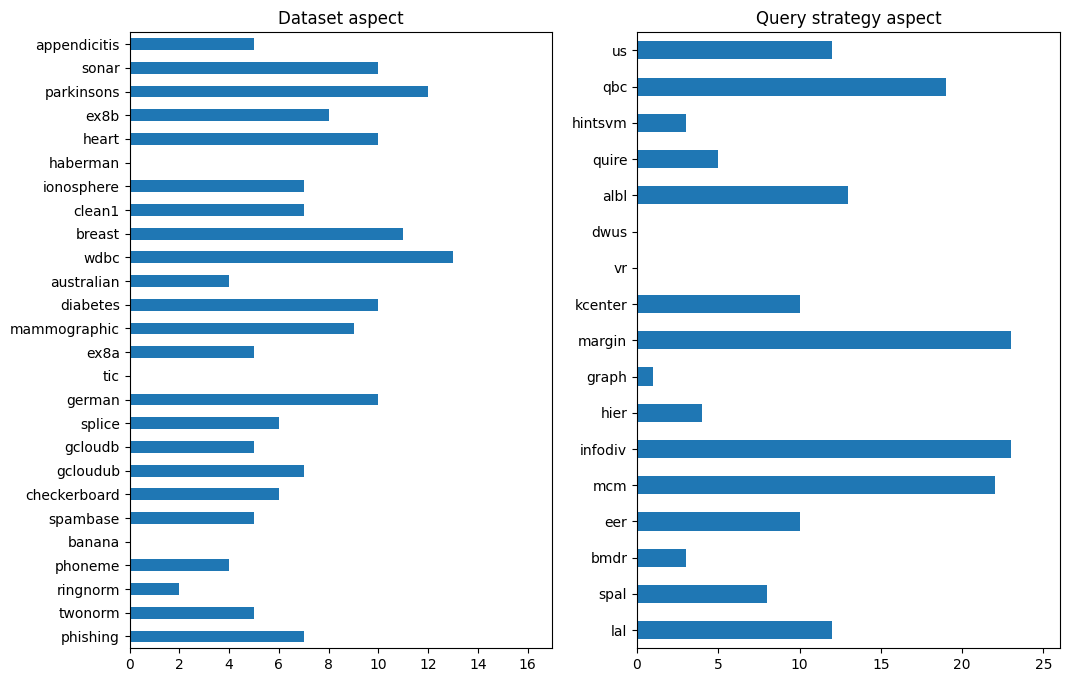

In [79]:
fig, (ax_data, ax_qs) = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
report4_data.plot(kind='barh', ax=ax_data)
report4_qs.plot(kind='barh', ax=ax_qs)
ax_data.set_title('Dataset aspect')
ax_data.set_ylabel('')
ax_data.invert_yaxis()
ax_data.set_xlim(0, 17)
ax_qs.set_title('Query strategy aspect')
ax_qs.set_ylabel('')
ax_qs.set_xlim(0, 26)
ax_qs.invert_yaxis()
fig.savefig('aubc/output/n_QSgtRS.png', bbox_inches='tight')